# Very simple model selection example

In [1]:
%matplotlib nbagg
%pylab

Using matplotlib backend: nbAgg
Populating the interactive namespace from numpy and matplotlib


In this example I want to show some of fito's features by example.
I'm going to use the famous Iris-Setosa dataset and perform a very small model selection over, from getting the data to evaluation metrics

In this first cell we just define where we are goint to store intermediate computations. It's not really needed for datasets this size, but when computations take long this might be useful

In [2]:
from fito.data_store import FileDataStore

ds = FileDataStore('caches')

## Getting the data

To get the data I just coded a function to get it, and decorated it with the `as_operation` decorator.
`get_data` is not a subclass of `Operation` whose executions are going to automatically cache into ds

The benefits from this, is that you don't have to think about how you call the file, and get lost in versions. Everything just happens

In [3]:
from urlparse import urljoin
from urllib import urlopen
from StringIO import StringIO
import csv
from collections import namedtuple
from fito import as_operation

Dataset = namedtuple('Dataset', ('X', 'y'))

@as_operation()
def get_data():
    base_url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/iris/'
    raw_data = urlopen(urljoin(base_url, 'iris.data')).read()
    
    fields = 's_length', 's_width', 'p_length', 'p_width', 'class'
    
    rows = [
        dict(zip(fields, row))
        for row in csv.reader(StringIO(raw_data))
        if row
    ]
    
    y = [e['class'] for e in rows]
    
    X = []
    for e in rows:
        e = e.copy()
        e.pop('class')
        X.append(e)
    
    return Dataset(X=X, y=y)

## Preparing the data to feed it into the model

In order to prepare the data I defined three more operations.

* `build_vectorizer`: Builds the vectorizer for `X`
* `class_to_int`: Builds the mapping from class string to int
* `get_vectorized_datasets`: Builds the actual vectorized dataset

As you can see, there are anotations given to `as_operation`. 
These annotations now just do type checking, but in the future will be the basis to perform automatic dependency analysis

In [4]:
from sklearn.feature_extraction import DictVectorizer

@as_operation(data=get_data)
def build_vectorizer(data):
    res = DictVectorizer(sparse=False)
    res.fit(data.X)
    return res

@as_operation(data=get_data)
def class_to_int(data):
    return {cls: i for i, cls in enumerate(set(data.y))}

@as_operation(data=get_data, vectorizer=build_vectorizer, class_to_int=class_to_int)
def get_vectorized_dataset(data, vectorizer, class_to_int):
    X = vectorizer.transform(data.X)
    y = np.asarray([class_to_int[cls] for cls in data.y])
    return Dataset(X=X, y=y)
    

## Split training from testing

Now that we have prepared our data, let's split it into training and testing.

In [5]:
import numpy as np
from random import Random

@as_operation(vectorized_dataset=get_vectorized_dataset)
def split(vectorized_dataset, mode, training_pct=0.8):
    assert mode in ['training', 'testing', 'development']
    
    rnd = np.random.RandomState(42)
    rnd_vals = rnd.rand(len(vectorized_dataset.y))
    
    if mode == 'training':
        mask = rnd_vals > 1 - training_pct
    else:
        remaining = 1 - training_pct
        if mode == 'testing':
            mask = rnd_vals <= remaining / 2
        else: # mode == 'development'
            mask = (remaining / 2 < rnd_vals) & (rnd_vals <= remaining)
    
    return Dataset(X=vectorized_dataset.X[mask], y=vectorized_dataset.y[mask])

## Experiment

We now have our source of data, let's build an experiment. 
I coded a simple class for an experiment. An experiment receives a `model` and a source of `data`, fits the model and performs some evaluations

In [6]:
from fito import OperationField, Operation
from sklearn.metrics import precision_score, recall_score, roc_auc_score

class Experiment(Operation):
    model = OperationField(0)
    tr_set = OperationField(1, base_type=split)
    dev_set = OperationField(2, base_type=split)
    default_data_store = ds
    
    def apply(self, runner):        
        tr_set = runner.execute(self.tr_set)
        dev_set = runner.execute(self.dev_set)
        
        model = runner.execute(self.model)
        model.fit(tr_set.X, tr_set.y)
        self.trained_model = model

        tr_pred = model.predict(tr_set.X)
        dev_pred = model.predict(dev_set.X)
        
        return {
            'tr_prec': precision_score(tr_set.y, tr_pred, average='macro'),
            'tr_rec': recall_score(tr_set.y, tr_pred, average='macro'),
            
            'dev_prec': precision_score(dev_set.y, dev_pred, average='macro'),
            'dev_rec': recall_score(dev_set.y, dev_pred, average='macro'),

        }
    
    @classmethod
    def build(cls, data, model, out_data_store):
        return cls.auto_instance(
            locals=dict(
                tr_set=dict(mode='training'),
                dev_set=dict(mode='development'),
            ),
            globals=dict(
                model=model,
                data=data,  
                out_data_store=out_data_store
            )
        )

## Creating some experiments

Now we can run some experiments. We are going to use a wrapper of scikit learn's `LogisticRegression` and test with tree values for the `C` parameter

In [7]:
from fito.model.scikit_learn import LogisticRegression

experiments = []

for c in [0.1, 0.3, 1, 3, 10]:
    model_operation = LogisticRegression(C=c)
    data = get_data()
    experiments.append(
        Experiment.build(
            model = LogisticRegression(C=c),
            data = get_data(),
            out_data_store = ds
        )
    )

## Wanna store this on a config file to run a single model?

No problemo!

In [8]:
print experiments[0].yaml.dumps()

dev_set:
  mode: development
  training_pct: 0.8
  type: __main__:split
  vectorized_dataset:
    class_to_int:
      data:
        type: __main__:get_data
      type: __main__:class_to_int
    data:
      type: __main__:get_data
    type: __main__:get_vectorized_dataset
    vectorizer:
      data:
        type: __main__:get_data
      type: __main__:build_vectorizer
model:
  C: 0.1
  class_weight: null
  dual: false
  fit_intercept: true
  intercept_scaling: 1
  max_iter: 100
  multi_class: ovr
  n_jobs: 1
  penalty: l2
  random_state: null
  solver: liblinear
  tol: 0.0001
  type: fito.model.scikit_learn:LogisticRegression
  verbose: 0
  warm_start: false
tr_set:
  mode: training
  training_pct: 0.8
  type: __main__:split
  vectorized_dataset:
    class_to_int:
      data:
        type: __main__:get_data
      type: __main__:class_to_int
    data:
      type: __main__:get_data
    type: __main__:get_vectorized_dataset
    vectorizer:
      data:
        type: __main__:get_data
      

/Users/pablo/prog/fito/fito/specs/base.py:350: MainModuleWarning: 
                The module of <class '__main__.Experiment'> is __main__.
                It's likely that you are not going to be able to desserialize this spec
                
  MainModuleWarning
/Users/pablo/prog/fito/fito/specs/base.py:350: MainModuleWarning: 
                The module of <class '__main__.split'> is __main__.
                It's likely that you are not going to be able to desserialize this spec
                
  MainModuleWarning
/Users/pablo/prog/fito/fito/specs/base.py:350: MainModuleWarning: 
                The module of <class '__main__.get_vectorized_dataset'> is __main__.
                It's likely that you are not going to be able to desserialize this spec
                
  MainModuleWarning
/Users/pablo/prog/fito/fito/specs/base.py:350: MainModuleWarning: 
                The module of <class '__main__.class_to_int'> is __main__.
                It's likely that you are not going to be

In [9]:
warnings.filterwarnings('ignore', '.*?__main__.*?')

## Running the experiments

In [10]:
from fito import OperationRunner
from fito import DictDataStore

experiment_ds = DictDataStore()
ds.clean()
runner = OperationRunner(execute_cache_size=50)

for e in experiments:
    experiment_ds[e] = runner.execute(e)

In [11]:
import pandas as pd
docs = []

for exp, stats in experiment_ds.iteritems():
    doc = {
        'C': exp.model.C,
        'exp': exp
    }
    doc.update(stats)
    
    docs.append(doc)

df = pd.DataFrame(docs).set_index('C').sort_index()

In [12]:
df

,dev_prec,dev_rec,exp,tr_prec,tr_rec
C,,,,,
0.1,1.0,1.0,<__main__.Experiment object at 0x10f00ea50>,0.974123,0.974731
0.3,1.0,1.0,<__main__.Experiment object at 0x10f00ed10>,0.982861,0.982861
1.0,1.0,1.0,<__main__.Experiment object at 0x10f00efd0>,0.992063,0.990991
3.0,1.0,1.0,<__main__.Experiment object at 0x10f0172d0>,1.000000,1.000000
10.0,1.0,1.0,<__main__.Experiment object at 0x10f017590>,1.000000,1.000000


<IPython.core.display.Javascript object>


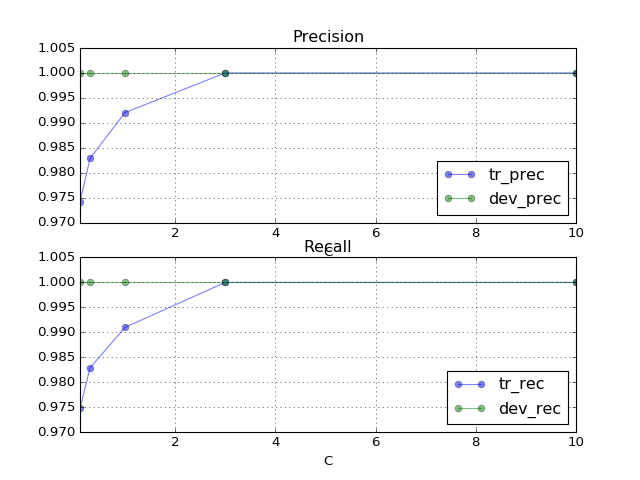

In [13]:
figure()

subplot(211)
title('Precision')

df.tr_prec.plot(style='-o', alpha=0.5)
df.dev_prec.plot(style='-o', alpha=0.5)
grid()
legend(loc='best')

subplot(212)
title('Recall')

df.tr_rec.plot(style='-o', alpha=0.5)
df.dev_rec.plot(style='-o', alpha=0.5)
grid()
legend(loc='best')
